# universal estimator

## Exp-1
Show that the error decreases when the parameter search space gets smaller.

**Research question**: Is the search space size of the parameter $d$ of a univariate distribution $f(d)$ has an affect on the learning and the prediction errors?

Let $f(d)$ be a one dimensional function, that returns a samples vector drawn from a univariate distribution (e.g., log-normal).

1. Generate a (256) samples vector using e.g: data = f(d=0.92)
2. Write a function: $estimator(f, data)$ which learns the parameter $d$ of $f$ from the $data$.

> - Init: search_space = (0,1)
> - Iterate (stop when the search-space size reaches some fraction, e.g. 1/128, of the initial search space)
>   1. Generate synthetic data-sets ( train / test ) using $f$ (within the parameter search space)
>   2. Fit a DNN model, error = | pred-set - test-set |
>   3. Predict the parameter $d\_pred$ on the input data
>   4. Narrow the search space:
>          pivot = d_pred # parameter predicted on input data using learning model
>          margin = 2 * std(abs error of pred vs. test)
>          search_space = ( pivot - margin, pivot  + margin )

3. Plot a graph:
   - $x$: size of search space
   - $y$: error
   - show that the size of the error converges to a lower limit (asymptotically)

**Results**:
- The experiment was run on the following true parameter values ( $d\_true$ ) : (0.92, 0.85, 0.66, 0.25)
- Search-space narrowing using margin = $1*STD$ and $2*STD$ (as described above)
- Learning on [N=1000, M=256] samples at each chosen search-space
- Values measured:
    - $MAE(pred, test)$ : $mean\_absolute\_error$ ( predict(model, X_test), test-set )
    - $d\_pred=predict\;(\;model, data\;)$
    - $d\_pred\_error = np.abs(d\_pred, d\_true)$

In addition, I used additional measure:
   - $d\_pred\_best\_data$ : the prediction $d\_pred$ which produced $data\_pred$ with the smallest absolute error from $data$ in all search-spaces.

As can be shown by the plots produced in the experiment:

1. $MAE(pred, test)$ decreases monotonically as we narrow the search-space. (exceptions in some runs?)
2. $d\_pred$, **does not** consistantly decrease we narrow the search-space (different runs produce different results).

**Observation**: 
- The search-space at each iteration is centered at ($pivot=d\_pred$) and depends on the $margin=STD(MAE(pred, test))$.  
If the error variance of $d\_pred$ is large, the true value $d\_true$ may sometimes go out of the search-space.  
This can be seen frequently when using $margin=1*STD$ but may happen also with $margin=2*STD$.

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
def next_config(param_search_space):
    """
    return a random (uniform)parameter within param_search_space
    """
    low = param_search_space[0]
    high = param_search_space[1]
    if None != RS:
        return RS.uniform(low, high, size=1)[0]
    return np.random.uniform(low, high, size=1)[0]

def estimator_exp_1(f, data, d_true,
                    initial_param_search_space=np.array([0.0,1.0])):
    """
    Learn parameters of f, from the data.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - data: samplesarray generated using f.
    """

    # experiment result: [ (size of search space, test_MAE) ]
    res = {
        'param_search_space': [],
        'test_MAE': [],
        'd_true': d_true,
        'd_pred_MAE': [],
        'd_pred_best_MAE': [],
        'd_pred': [],
        'd_pred_best': 0,
    }
   
    # number of samples in data
    M = len(data)
    N = 1000

    d_pred_best = -1
    data_MAE_best = -1
    
    # Iterate
    param_search_space = initial_param_search_space
    while True:
        
        # 1. Generate synthetic learning data-sets (train/test) using f (within param_search_space)
        # -----------------------------------------------------------------------------------------
        print()
        print(f'generating data (M={M}, N={N}) param_search_space: {param_search_space} ...', end=' ')
        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(param_search_space),
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)
        print(f'histogram shape: {H_train.shape}')

        # 2. Fit a DNN model to train-set and predict on test-set, error = | pred-set - test-set |
        # -----------------------------------------------------------------------------------------
        
        print(f'fitting dnn model ...', end=' ')
        start_time = time.time()
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
        train_time = time.time() - start_time

        test_pred = dnn_model.predict(H_test).flatten()
        test_MAE = mean_absolute_error(test_params, test_pred)
        print(f'test_MAE: {test_MAE:.4f}', end=', ')

        # 3. Predict the parameter d on the input data (d_pred)
        # -----------------------------------------------------------------------------------------

        nbins = H_train.shape[1]
        h_data = np.histogram(data, bins=nbins, range=(0,nbins), density=False)[0]
        h_data = np.reshape(h_data, (1, -1))
        d_pred = dnn_model.predict(h_data).flatten()[0]
        print(f'd_pred: {d_pred:.4f}, abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
        
        #lilo:
#         data_pred = f(d_pred, size=M)
#         data_MAE = mean_absolute_error(data_pred, data)
        # generate several samples using *d_pred* to determine the avg MAE against *data*
        repeat = 10
        data_pred, _, _ = generate_data(N=repeat, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=d_pred,
                                       density=False, 
                                       apply_log_scale=False)
        data_MAE = np.mean(mean_absolute_error(data_pred, np.repeat(data, repeat).reshape(repeat,-1)))
        print(f'data_MAE: {data_MAE:.4f}', end= ', ')
        if data_MAE_best < 0 or data_MAE < data_MAE_best:
            data_MAE_best = data_MAE
            d_pred_best = d_pred
        print(f'data_MAE_best: {data_MAE_best:.4f}', end= ', ')
        print(f'd_pred_best: {d_pred_best:.4f}')
        
        # save results
        res['param_search_space'].append(param_search_space)
        res['test_MAE'].append(test_MAE)
        res['d_pred_MAE'].append(abs(d_pred - d_true))
        res['d_pred_best_MAE'].append(abs(d_pred_best - d_true))
        res['d_pred'].append(d_pred)
        res['d_pred_best'] = d_pred_best
        
        # 4. Narrow the search space:
        # -----------------------------------------------------------------------------------------
        test_STD_abs_error = np.std( np.abs(test_params, test_pred) )
        margin_std_factor = 1
#         margin_std_factor = 2
        margin = margin_std_factor * test_STD_abs_error
        
        pivot = d_pred
        print(f'pivot=d_pred: {pivot:.4f}, margin={margin_std_factor}*test_STD_abs_error: {margin:.4f}')
        
        next_search_space = np.array([ 
            max(param_search_space[0], pivot - margin), 
            min(param_search_space[1], pivot + margin)])
#         next_search_space = np.array([ 
#             max(initial_param_search_space[0], pivot - margin), 
#             min(initial_param_search_space[1], pivot + margin)])
        
        if np.array_equal(param_search_space, next_search_space):
            # if no change in param_search_space, narrow by epsilon (from both sides)
#             epsilon = 0.001
#             epsilon = test_STD_abs_error
            epsilon = 0.1 * test_STD_abs_error
            print(f'no change in param_search_space. narrowing by epsilon: {epsilon:.4f}')
            param_search_space = np.array([param_search_space[0] + epsilon, param_search_space[1] - epsilon])
        else:
            count_no_change_in_search_space = 0
            param_search_space = next_search_space
        
        # stop condition
        # size of the search-space (high-low) is 1/128 of the original
        # -----------------------------------------------------------------------------------------
        
        param_search_space_width = param_search_space[1] - param_search_space[0]
        initial_param_search_space_width = initial_param_search_space[1] - initial_param_search_space[0]
        search_space_shrink_factor = 1/16
        if margin_std_factor < 2:
            search_space_shrink_factor = 1/128
        if param_search_space_width < search_space_shrink_factor * initial_param_search_space_width:
            print('stop -----------------------------------------------------------------')
            print(f'param_search_space_width: {param_search_space_width:.4f}')
            print(f'test_MAE: {test_MAE:.4f}')
            print(f'd_pred: {d_pred:.4f}, abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
            break
            
    return res

### Plot helper

In [3]:
def plot_search_space_size_vs_error(res):

    param_search_space = np.array(res['param_search_space'])
    param_search_space_width = param_search_space[:,1] - param_search_space[:,0]
    d_true = res['d_true']
    test_MAE = res['test_MAE']
    d_pred_MAE = res['d_pred_MAE']
    d_pred_best_MAE = res['d_pred_best_MAE']
    d_pred = res['d_pred'][-1]
    d_pred_best = res['d_pred_best']
    
    title = f'search space vs. error \n\
    ( final param_search_space: {param_search_space[-1]}) \n\
    ( d_true={d_true}, d_pred: {d_pred:.4f}, d_pred_best: {d_pred_best:.4f} )'
    
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.xlabel('search space')
    plt.ylabel('error')

    x = param_search_space_width
    y = test_MAE
    plt.scatter(x, y, zorder=1, s=2, c='blue', label='test_MSE')
    plt.plot(x, y, zorder=2, c='blue')

    y = d_pred_MAE
    plt.scatter(x, y, zorder=1, s=2, c='orange', label='abs(d_pred - d_true)')
    plt.plot(x, y, zorder=2, c='orange')
    
    y = d_pred_best_MAE
    plt.scatter(x, y, zorder=1, s=2, c='red', label='abs(d_pred_best - d_true)')
    plt.plot(x, y, zorder=2, c='red')
    
    plt.legend()
    plt.show()


### Fit (lognormal)


param true value: 0.92

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 54)
fitting dnn model ... test_MAE: 0.0539, d_pred: 0.9804, abs(d_pred - d_true): 0.0604
data_MAE: 1.8239, data_MAE_best: 1.8239, d_pred_best: 0.9804
pivot=d_pred: 0.9804, margin=1*test_STD_abs_error: 0.2963

generating data (M=256, N=1000) param_search_space: [0.6841 1.    ] ... histogram shape: (750, 48)
fitting dnn model ... test_MAE: 0.0430, d_pred: 0.9600, abs(d_pred - d_true): 0.0400
data_MAE: 1.7508, data_MAE_best: 1.7508, d_pred_best: 0.9600
pivot=d_pred: 0.9600, margin=1*test_STD_abs_error: 0.0939

generating data (M=256, N=1000) param_search_space: [0.8661 1.    ] ... histogram shape: (750, 64)
fitting dnn model ... test_MAE: 0.0300, d_pred: 0.9345, abs(d_pred - d_true): 0.0145
data_MAE: 1.7183, data_MAE_best: 1.7183, d_pred_best: 0.9345
pivot=d_pred: 0.9345, margin=1*test_STD_abs_error: 0.0373

generating data (M=256, N=1000) param_search_space: [0.8972 0.9718] ...

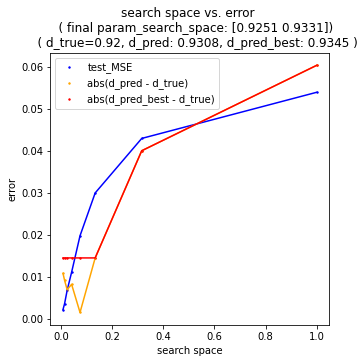


param true value: 0.85

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 54)
fitting dnn model ... test_MAE: 0.0539, d_pred: 0.9099, abs(d_pred - d_true): 0.0599
data_MAE: 1.6175, data_MAE_best: 1.6175, d_pred_best: 0.9099
pivot=d_pred: 0.9099, margin=1*test_STD_abs_error: 0.2963

generating data (M=256, N=1000) param_search_space: [0.6136 1.    ] ... histogram shape: (750, 46)
fitting dnn model ... test_MAE: 0.0425, d_pred: 0.8717, abs(d_pred - d_true): 0.0217
data_MAE: 1.5445, data_MAE_best: 1.5445, d_pred_best: 0.8717
pivot=d_pred: 0.8717, margin=1*test_STD_abs_error: 0.1148

generating data (M=256, N=1000) param_search_space: [0.7569 0.9865] ... histogram shape: (750, 49)
fitting dnn model ... test_MAE: 0.0418, d_pred: 0.8867, abs(d_pred - d_true): 0.0367
data_MAE: 1.5450, data_MAE_best: 1.5445, d_pred_best: 0.8717
pivot=d_pred: 0.8867, margin=1*test_STD_abs_error: 0.0640

generating data (M=256, N=1000) param_search_space: [0.8228 0.9507] ...

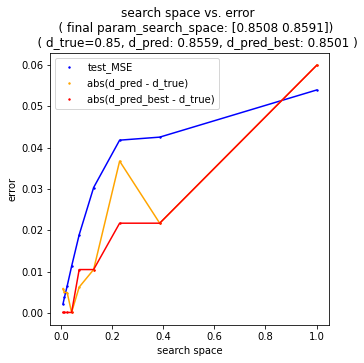


param true value: 0.66

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 54)
fitting dnn model ... test_MAE: 0.0539, d_pred: 0.6988, abs(d_pred - d_true): 0.0388
data_MAE: 1.1640, data_MAE_best: 1.1640, d_pred_best: 0.6988
pivot=d_pred: 0.6988, margin=1*test_STD_abs_error: 0.2963

generating data (M=256, N=1000) param_search_space: [0.4026 0.9951] ... histogram shape: (750, 44)
fitting dnn model ... test_MAE: 0.0391, d_pred: 0.7121, abs(d_pred - d_true): 0.0521
data_MAE: 1.1577, data_MAE_best: 1.1577, d_pred_best: 0.7121
pivot=d_pred: 0.7121, margin=1*test_STD_abs_error: 0.1761

generating data (M=256, N=1000) param_search_space: [0.536  0.8881] ... histogram shape: (750, 31)
fitting dnn model ... test_MAE: 0.0378, d_pred: 0.8046, abs(d_pred - d_true): 0.1446
data_MAE: 1.2209, data_MAE_best: 1.1577, d_pred_best: 0.7121
pivot=d_pred: 0.8046, margin=1*test_STD_abs_error: 0.0981

generating data (M=256, N=1000) param_search_space: [0.7065 0.8881] ...

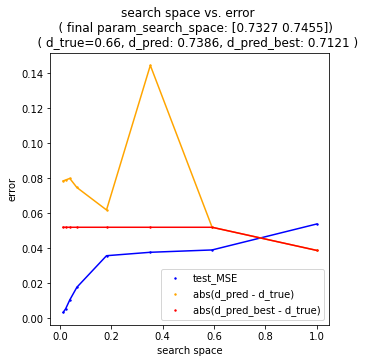


param true value: 0.25

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 54)
fitting dnn model ... test_MAE: 0.0539, d_pred: 0.2072, abs(d_pred - d_true): 0.0428
data_MAE: 0.6375, data_MAE_best: 0.6375, d_pred_best: 0.2072
pivot=d_pred: 0.2072, margin=1*test_STD_abs_error: 0.2963

generating data (M=256, N=1000) param_search_space: [0.     0.5035] ... histogram shape: (750, 6)
fitting dnn model ... test_MAE: 0.0468, d_pred: 0.3033, abs(d_pred - d_true): 0.0533
data_MAE: 0.6501, data_MAE_best: 0.6375, d_pred_best: 0.2072
pivot=d_pred: 0.3033, margin=1*test_STD_abs_error: 0.1496

generating data (M=256, N=1000) param_search_space: [0.1537 0.4529] ... histogram shape: (750, 5)
fitting dnn model ... test_MAE: 0.0292, d_pred: 0.2772, abs(d_pred - d_true): 0.0272
data_MAE: 0.6316, data_MAE_best: 0.6316, d_pred_best: 0.2772
pivot=d_pred: 0.2772, margin=1*test_STD_abs_error: 0.0834

generating data (M=256, N=1000) param_search_space: [0.1938 0.3605] ... h

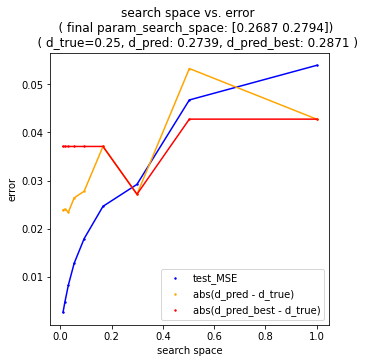

In [4]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

# fit
def exp_1():
    for d_true in [0.92, 0.85, 0.66, 0.25]:
        reset_random_state(SEED)
        print()
        print(f'param true value: {d_true}')
        data = sample_lognormal(config=d_true, size=256)
        res = estimator_exp_1(f=sample_lognormal, data=data, d_true=d_true)
        plot_search_space_size_vs_error(res)

exp_1()

## Exp-2: 
Show that the error of predicting the input data is "same" as for predicting the test-set

**Research question**: TBD

- Calculate the variance of the error $e = (d\_pred - d\_true)$ produced above.

> $ var_1(e) = E [ ( e - mean(e) ) ^ 2 ] = 1/n * \sum_i { ( e_i - mean(e) ) } ^ 2 $

> $ \sigma_1(e) = \sqrt { var_1(e) } $


- Calculate the avg. error of $\sigma_1(e)$:

> $ var_2(e) = 1/n * \sum_i { [ ( e_i - mean(e) ) ^ 2 - \sigma_1(e) ^ 2 ] } $

> $ \sigma_2(e) = \sqrt { var_2(e) } $

- Plot a graph:

> x: size of search-space

> y: error(data) in red, error(test-data) in blue, confidence interval (sigma_2)

In [5]:
def exp_2():
    reset_random_state(SEED)
    d_true = 0.72
    print()
    print(f'param true value: {d_true}')
    data = sample_lognormal(config=d_true, size=256)
    res = estimator_exp_1(f=sample_lognormal, data=data, d_true=d_true)
    
    d_pred = np.array(res['d_pred'])
    
    e = d_pred - d_true
    
    n = len(d_pred)
    
    # Calculate the variance of the error
    var_1 = 1/n * np.sum( np.sqrt( np.square( e - np.mean(e) ) ) )
    sigma_1 = np.sqrt(var_1)
    print()
    print(f'var_1: {var_1:.4f}, sigma_1: {sigma_1:.4f}')
    
    # Calculate the avg. error of sigma_1
#     var_2 = 1/n * np.sum( np.square( e - np.mean(e) ) - np.square(sigma_1) )
#     sigma_2 = np.sqrt(var_2)
#     print()
#     print(f'var_2: {var_2:.4f}, sigma_2: {sigma_2:.4f}')

exp_2()


param true value: 0.72

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 54)
fitting dnn model ... test_MAE: 0.0539, d_pred: 0.7412, abs(d_pred - d_true): 0.0212
data_MAE: 1.2719, data_MAE_best: 1.2719, d_pred_best: 0.7412
pivot=d_pred: 0.7412, margin=1*test_STD_abs_error: 0.2963

generating data (M=256, N=1000) param_search_space: [0.445 1.   ] ... histogram shape: (750, 45)
fitting dnn model ... test_MAE: 0.0413, d_pred: 0.8194, abs(d_pred - d_true): 0.0994
data_MAE: 1.3153, data_MAE_best: 1.2719, d_pred_best: 0.7412
pivot=d_pred: 0.8194, margin=1*test_STD_abs_error: 0.1649

generating data (M=256, N=1000) param_search_space: [0.6544 0.9843] ... histogram shape: (750, 46)
fitting dnn model ... test_MAE: 0.0423, d_pred: 0.7718, abs(d_pred - d_true): 0.0518
data_MAE: 1.2587, data_MAE_best: 1.2587, d_pred_best: 0.7718
pivot=d_pred: 0.7718, margin=1*test_STD_abs_error: 0.0919

generating data (M=256, N=1000) param_search_space: [0.6799 0.8637] ... h